# The Expected Value of an NBA Draft Pickv2

## 1.0 Introduction

The game of basketball is forever changing. Trends come and go, teams rise and fall, players' legacies are constantly being  written and re-written. 

Perhaps more than in any other sport, a single player can be the difference maker for a franchise. While teams can acquire players through a few different methods (drafts, signings, and trades), some of the most compelling stories in the NBA explore a "Chosen One" narrative: a young prospect turned superstar that brings the team that drafted them into championship contetion. (Ex: Magic Johson, Tim Duncan, LeBron James)

For every success story, however, there are a few "busts" along the way. How often do we see a team place their hopes in some 19-20 year old touted as "The Next Michael Jordan" only for this same team to remain in the lottery for years to come? On the other end, there are some "hidden gems" taken later in the draft that surprise people with their production (Ex: Dennis Rodman, Manu Ginobili , Nikola Jokic)

Human behaviour is so difficult to predict and there are limitless factors that effect player performance. Teams might not always scout correctly or coach properly, and players might not perform or develop as expected. Win Shares, VORP, and Plus/Minus are far from perfect measures of player value, and there are so many unfounded expectations and overwhelming uncertainties. Such is the nature of the NBA Draft.

**In this article, I aim to quantify value of different draft picks and explore how draft position might be related to player performance**. We likely will not find a terribly strong, generalizable model in our analysis, but this exploration *might* still provide insight on the nature of NBA draft picks.

## 2.0 Methodology

**Sample**: We have pulled 22 draft classes (1989 to 2011) as our sample (n = 1322 draftees).

We begin from 1989 because the modern draft format (two rounds of draft picks) was introduced in 1989, and the NBA has kept the two-round format since then. We end with 2011 because there are players drafted in 2012 and beyond that might still produce "prime" seasons.

**Data Sources**: I pulled Draft Position data and Regular Season data from [Stathead.com][2]. Shoutouts to their team for assisting me on using their tools!

**Player Value**: To measure the “value” of each draftee, I am using a statistic referenced on [BoxScoreGeeks.com][1]: Brocato Prime Wins. We are interested in a draftee’s **five** best regular seasons organized by **total Win Shares** (WS). 

We will refer to this measure as "Prime Win Shares", "Prime Wins", or "Prime WS" from this point forward.

**Notes**:
1. What to do with draftees that did not play in the NBA or play 5 seasons?
    * We will include any/all the seasons we can, but seasons of absence we will fill with no production: 0 Win Shares.
    * Likewise, "non-players" will be treated as though they produced 0 Win Shares over their entire career.
    * We want to include these abscences because at the end of the day, we wish to determine the value of a draft pick. Even if the draft pick was used on a player that never played in the NBA, this should still be accounted for in our dataset.

2. Why use total Win Shares instead of time/pace adjusted measures?
    * I decided to use total Win Shares over Win Shares per 48 Minutes (WS/48), because I wanted to value overall impact over efficiency.
    * Players with high WS/48 might be highly efficient, but their impact is limited if they are rarely on the court.
    * A player with relatively lower WS/48 that plays many more minutes arguably provides greater utility for a team/franchise.

3. Why are we using the five best seasons?
    * According to [The Guardian][3], The average nba career length is around 4.9 years. Five seasons of data should cover the average nba career.
    * Using the five *best* seasons will give us an idea of the player's peak while balancing some level of longevity.

**Confounding Effects?**

1. Draft Position and Team Investment
    * Differences in draft position may be coupled with different degrees of team investment.
    * Franchises could be more inclined to build their team around a player on which they have used a higher draft pick. This would could positvely impact draftee's on court performance.
    * By design, higher draft picks are supposed to go to worse teams. Less talented prospects might not have to play as well to be awarded with more minutes, and on average, more minutes produces more Win Shares. 


2. Draft Position and Personal Investment
    * Differenes in draft position come with differences in player salary.
    * Players with more money can afford to invest in themselves to a greater degree.
    * While teams/coaches should be investing in their own players, and the NBA pays its players very well, there is still an inherent difference in pay between different picks of the same draft class.
    * Ex: In 1989, the first overall pick, Pervis Ellison, recieved \\$2.4 million from the Sacremento Kings. The first pick in the 2nd round (28th overall), Sherman Douglas, was only paid \\$325k. 
    

[1]:https://www.boxscoregeeks.com/articles/twenty-players-better-than-kobe "Some Kobe H8er Article"
[2]:https://stathead.com/tiny/Vmzxj "Sharable Query Link"
[3]:https://www.theguardian.com/sport/2015/nov/30/the-kobe-bryant-outlier-how-his-career-compares-to-the-nba-average#:~:text=Among%20the%203%2C668%20players%20Wilczynski,career%20length%20was%204.9%20years "The Kobe Bryant outlier"

In [48]:
#Importing Pandas, numpy and heapq
import pandas as pd
import numpy as np
import heapq
import math

In [49]:
#Loading the raw data
seasonDataRaw = pd.read_excel('SeasonStats_19892025.xlsx')
draftListRaw = pd.read_excel('DraftPosition_19892011.xlsx')

In [50]:
seasonDataRaw.head()

,Rk,Player,WS,Draft Team,Round,Pick,Draft Year,College,Season,Age,...,PER,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,Pos
0,201,Kenny Anderson,0.2,NJN,1,2,1991,Georgia Tech,2004-05,34,...,10.1,3.6,10.5,6.9,22.2,2.3,0.0,18.4,16.1,G
1,202,Nick Anderson,1.8,ORL,1,11,1989,Illinois,1989-90,22,...,14.9,6.1,12.7,9.3,10.5,1.8,1.0,13.7,22.1,F-G
2,203,Nick Anderson,3.1,ORL,1,11,1989,Illinois,1990-91,23,...,15.1,4.9,16.7,10.7,8.5,1.8,1.3,10.4,22.4,F-G
3,204,Nick Anderson,3.6,ORL,1,11,1989,Illinois,1991-92,24,...,16.4,4.8,14.9,9.7,12.4,2.2,0.9,9.7,24.5,F-G
4,205,Nick Anderson,7.7,ORL,1,11,1989,Illinois,1992-93,25,...,17.3,5.0,13.0,9.2,14.7,2.2,1.2,9.9,24.5,F-G


In [51]:
draftListRaw.head()

,Rk,Year,Lg,Rd,Pk,Tm,Player
0,1,1989,NBA,1,1,SAC,Pervis Ellison
1,2,1989,NBA,1,2,LAC,Danny Ferry
2,3,1989,NBA,1,3,SAS,Sean Elliott
3,4,1989,NBA,1,4,MIA,Glen Rice
4,5,1989,NBA,1,5,CHH,J.R. Reid


In [52]:
#Tapering down and merging the raw data into one dataframe.
#seasonData does not account for players that were drafted but didn't play in the NBA. Which is why we need to join on draftList
draftList = draftListRaw[['Player', 'Year', 'Pk']]
seasonData = seasonDataRaw[['Player', 'Season', 'WS', 'Draft Year', 'Pick']]
df0 = pd.merge(draftList, seasonData
               , left_on=['Year', 'Pk']
               , right_on= ['Draft Year', 'Pick']
               , how = 'left')

In [53]:
df0.head()

,Player_x,Year,Pk,Player_y,Season,WS,Draft Year,Pick
0,Pervis Ellison,1989,1,Pervis Ellison,1989-90,0.4,1989.0,1.0
1,Pervis Ellison,1989,1,Pervis Ellison,1990-91,4.0,1989.0,1.0
2,Pervis Ellison,1989,1,Pervis Ellison,1991-92,6.9,1989.0,1.0
3,Pervis Ellison,1989,1,Pervis Ellison,1992-93,3.9,1989.0,1.0
4,Pervis Ellison,1989,1,Pervis Ellison,1993-94,0.7,1989.0,1.0


In [54]:
#Cleaning and creating a final dataframe
df = df0[['Player_x', 'Season', 'WS', 'Year', 'Pk']]
df = df.rename(columns={'Player_x': 'Player'})
#Adding an ID column as there are some players with the same name (Ex: 'Michael Johnson')
df['ID'] = df['Year'].astype(str) + df['Pk'].astype(str).str.zfill(2)

In [55]:
df.head()

,Player,Season,WS,Year,Pk,ID
0,Pervis Ellison,1989-90,0.4,1989,1,198901
1,Pervis Ellison,1990-91,4.0,1989,1,198901
2,Pervis Ellison,1991-92,6.9,1989,1,198901
3,Pervis Ellison,1992-93,3.9,1989,1,198901
4,Pervis Ellison,1993-94,0.7,1989,1,198901


In [56]:
#Saving as an excel file
#df.to_excel('WS_All.xlsx')

In [57]:
def playerPrime(df, id, b, n):
#This function returns n number of a players best seasons best seasons based on statistic b
    df['WS'] = df['WS'].fillna(0)
    prime = df.groupby(id, dropna=False)[b].nlargest(n).groupby(id).sum()
    df_noDup = df[['Player', 'ID', 'WS', 'Year', 'Pk']].drop_duplicates(subset=['ID']) 
    df_merge = pd.merge(prime, df_noDup, left_on=['ID'], right_on= ['ID'], how = 'left')
    df_merge = df_merge.rename(columns={'WS_x': 'Prime_WS'})
    df_prime = df_merge[['Player', 'Prime_WS', 'Year', 'Pk', 'ID']]
    return(df_prime)


In [58]:
#Saving as an excel file and creating a new dataframe
df_prime = playerPrime(df, 'ID', 'WS', 5)
#df_prime.to_excel('WS_Prime.xlsx')

df_prime.head()

,Player,Prime_WS,Year,Pk,ID
0,Pervis Ellison,19.2,1989,1,198901
1,Danny Ferry,22.7,1989,2,198902
2,Sean Elliott,39.7,1989,3,198903
3,Glen Rice,49.3,1989,4,198904
4,J.R. Reid,14.9,1989,5,198905


In [59]:
playerCount, classCount = df_prime['ID'].nunique(), df_prime['Year'].nunique()

print(f'There are ' +str(classCount)+ ' draft classes and ' +str(playerCount)+' players in our data set.')

There are 23 draft classes and 1322 players in our data set.


## 3.0 Analysis

### 3.1 Draft Position vs. Prime Wins: Ordinary Least Squares

In [60]:
#Importing statistical and visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [61]:
# Creating OLS model
ols_formula = 'Prime_WS ~ Pk'
OLS = ols(formula = ols_formula, data = df_prime)
model = OLS.fit()
model_results = model.summary()
# Display the model results.
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Prime_WS   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     516.3
Date:                Sat, 24 May 2025   Prob (F-statistic):           9.80e-97
Time:                        11:02:43   Log-Likelihood:                -5310.1
No. Observations:                1322   AIC:                         1.062e+04
Df Residuals:                    1320   BIC:                         1.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.8853      0.747     35.988      0.000      25.420      28.351
Pk            -0.5029      0.022    -22.722      0.000      -0.546      -0.459
==============================================================================
Omnibus:                      265.183   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.299
Skew:                           1.174   Prob(JB):                    3.84e-114
Kurtosis:                       4.991   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
model.params[1]

-0.5029125016659853

In [63]:
model.rsquared

0.28116575102252983

Text(0, 0.5, 'Prime Wins')

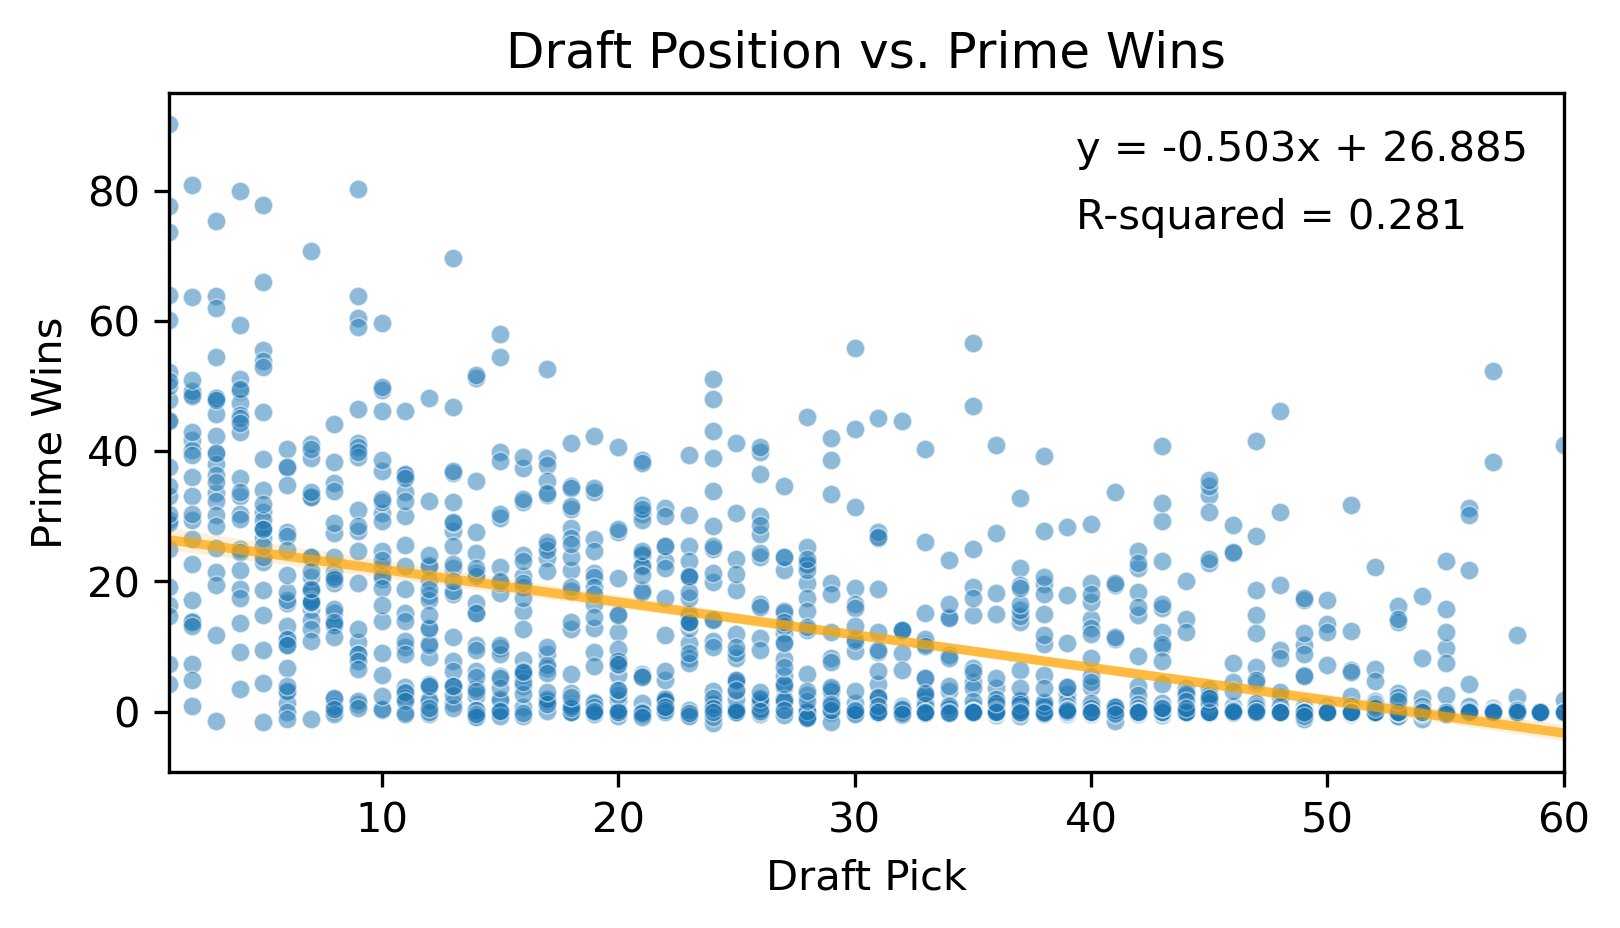

In [64]:
fig, ax = plt.subplots(figsize=(6,3), dpi = 300)

ax = sns.scatterplot(x=df_prime['Pk'], y=df_prime['Prime_WS'], s=20, alpha=0.5)
sns.regplot(x=df_prime['Pk'], y=df_prime['Prime_WS'], color='orange', line_kws=dict(alpha=0.7), scatter=False, ax=ax)

ax.text(0.65, 0.9, f'y = {model.params[1]:.3f}x + {model.params[0]:.3f}', transform=ax.transAxes)
ax.text(0.65, 0.8, f'R-squared = {model.rsquared:.3f}', transform=ax.transAxes)
plt.title('Draft Position vs. Prime Wins')
plt.xlabel('Draft Pick')
plt.ylabel('Prime Wins')

### 3.1.1 Linear Analysis: Initial Thoughts

The above shows all of the players plotted by their Draft Position & Prime Win Shares, a ordinarly least squares regression has also been applied to our data.

We *do* see that 'Pk'/'Draft Position' has a coefficent of **-0.5029** , signaling that teams generally select players that produce more Prime Wins earlier in the draft. We are able to generally oserve this trend from the scatterplot as well. The $R^2$ value is pretty weak at **0.281**.

Our current linear model is poorly describing our dataset. I am curious if applying a transform can improve our model, but I will test our below assumptions first to see if there is any additional insight I can gather from this analysis

    1. Linearity
    2. Independance
    3. Normality
    4. Homoscedasticity 

#### Assumption 1 & 4: Linearity & Homoscedasticity

It does seem that there is a slight funnel shape, meaning greater variace for earlier picks than later picks. There is also a very slight curve to the lowess trendline. We can continue checking our assumptions, but a log-transform could be something to consider.

Text(0.5, 1.0, 'Residual Plot')

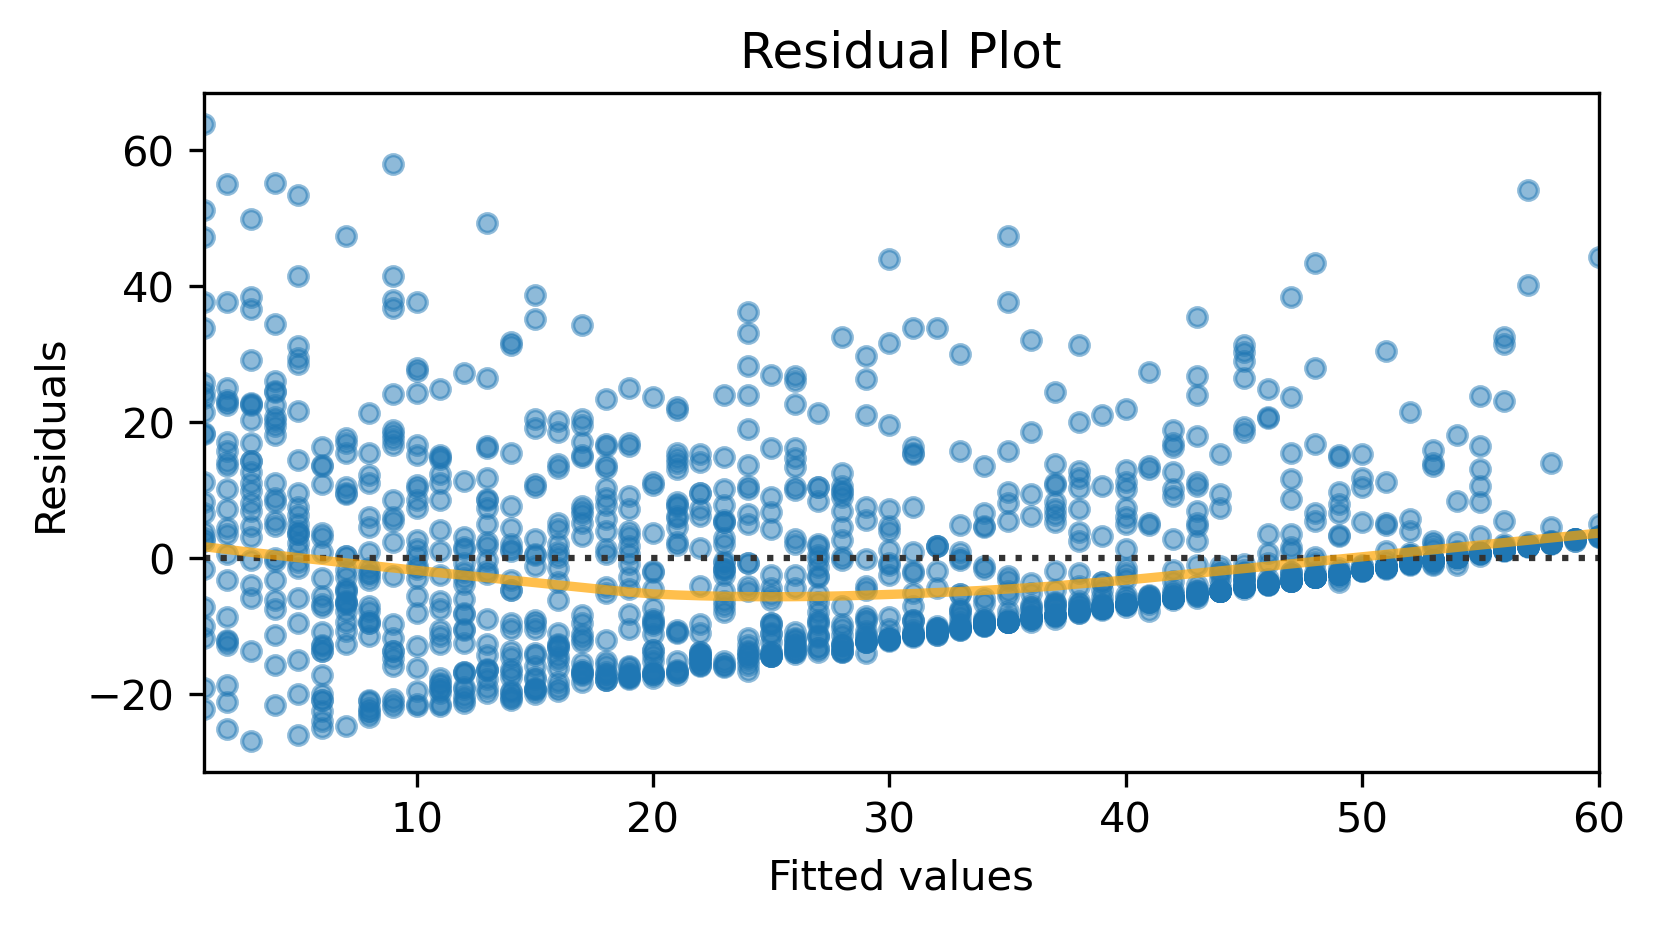

In [65]:
fig, ax = plt.subplots(figsize=(6,3), dpi = 300)

sns.residplot(x=df_prime['Pk'], y=df_prime['Prime_WS'], lowess=True, scatter_kws=dict(s=20, alpha=0.5), line_kws= dict(color='orange', alpha=0.7))
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

#### Assumption 2: Independance 

Admittedly, each draft pick (within the same draft) is NOT entirely independent of the other, but picks from one class to the other should be independent of one another, and for the purposes of our analysis, this should be sufficiently independent.

**Our Durbin-Watson metric of 1.811** from the above OLS Regression Results (section 3.1), indicate that there is no autocorrelation and therefore the observations are independent as this metric is between 1.5 to 2.5.

#### Assumption 3: Normality

Based on the Histogram and the Q-Q plot, we observe a strong right skew and some concavity. To address this skewness and better approximate normality, a **log transformation should be applied to the data**.

Text(0.5, 1.0, 'Normal Q-Q plot')

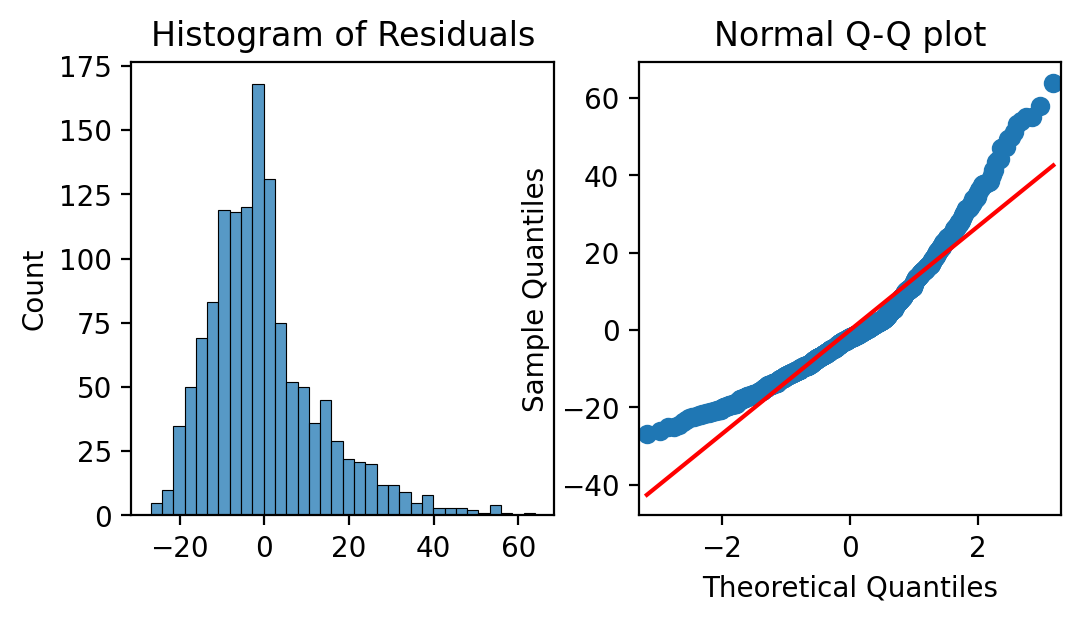

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi = 200) # 1 row, 2 columns

residuals = model.resid
sns.histplot(residuals, ax = axes[0])
axes[0].set_title('Histogram of Residuals')

sm.qqplot(residuals, line='s', ax = axes[1]);
plt.title('Normal Q-Q plot')

## 3.2 Draft Position vs. Prime Wins:  Log Transformation

From a narrative perspective, an inverse logarithmic relationship between Draft Position and Prime Wins would make sense as the league tends to be somewhat "top heavy" between players when investigating most statistics. On [Basketball-Reference.com][2], it even states that when looking at BPM, "there are far more below-average players than above-average players in the league at any time".

If we ignore undrafted players and assume draft pools mimic the player pool of the entire NBA, we can excpect each draft to be comprised of a few strong performers, while most of the draft is made up of less impactful players. Hence, \***there can be a large difference between selecting 1st and selecting 5th**.

On the other side, the difference between **the 55th and 60th picks may be relatively small** for somewhat related reasons. Towards the end of the draft, so more draftees also become "non-players" in our dataset. Whether these picks are were caught in a contract with another league, or just weren't impressing NBA teams, many later picks end up with 0 Prime Win Shares in our dataset.

This might "dampen' the value of later draft picks and might keep the average measure of Prime Wins closer to 0 for the later draft positions.

[2]:https://www.basketball-reference.com/about/bpm2.html

\* Note: Aiming to find one value for a specific draft position is also pretty unreasonable since every draft class is different. High draft picks will hold inconsistent value from year to year depending on the strength of the prospects. The 1st overall pick in particular has varied wildly over the years. Even at the time of their respective drafts, LeBron James was a very different prospect from someone like Anthony Bennet, Andrea Bargnani, or even LeBron's own teammate Anthony Davis.

### 3.2.1 Draft Position vs. log(Prime Wins) Results:

In [67]:
#Applying the log transform and translation because we have negative values
df_prime['log_PrimeWS'] = np.log(df_prime['Prime_WS']+(abs(df_prime['Prime_WS'].min())+1))

translation = abs(df_prime['Prime_WS'].min())+1
print(translation)

2.7


In [68]:
# Creating OLS model
ols_formulaLOG = 'log_PrimeWS ~ Pk'
OLSLog = ols(formula = ols_formulaLOG, data = df_prime)
modelLog = OLSLog.fit()
modelLog_results = modelLog.summary()
# Display the model results.
modelLog_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_PrimeWS   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     628.7
Date:                Sat, 24 May 2025   Prob (F-statistic):          8.49e-114
Time:                        11:02:46   Log-Likelihood:                -1743.1
No. Observations:                1322   AIC:                             3490.
Df Residuals:                    1320   BIC:                             3501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2108      0.050     63.836      0.000       3.112       3.309
Pk            -0.0374      0.001    -25.075      0.000      -0.040      -0.034
==============================================================================
Omnibus:                       11.499   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.107
Skew:                           0.156   Prob(JB):                      0.00639
Kurtosis:                       2.706   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Prime Wins')

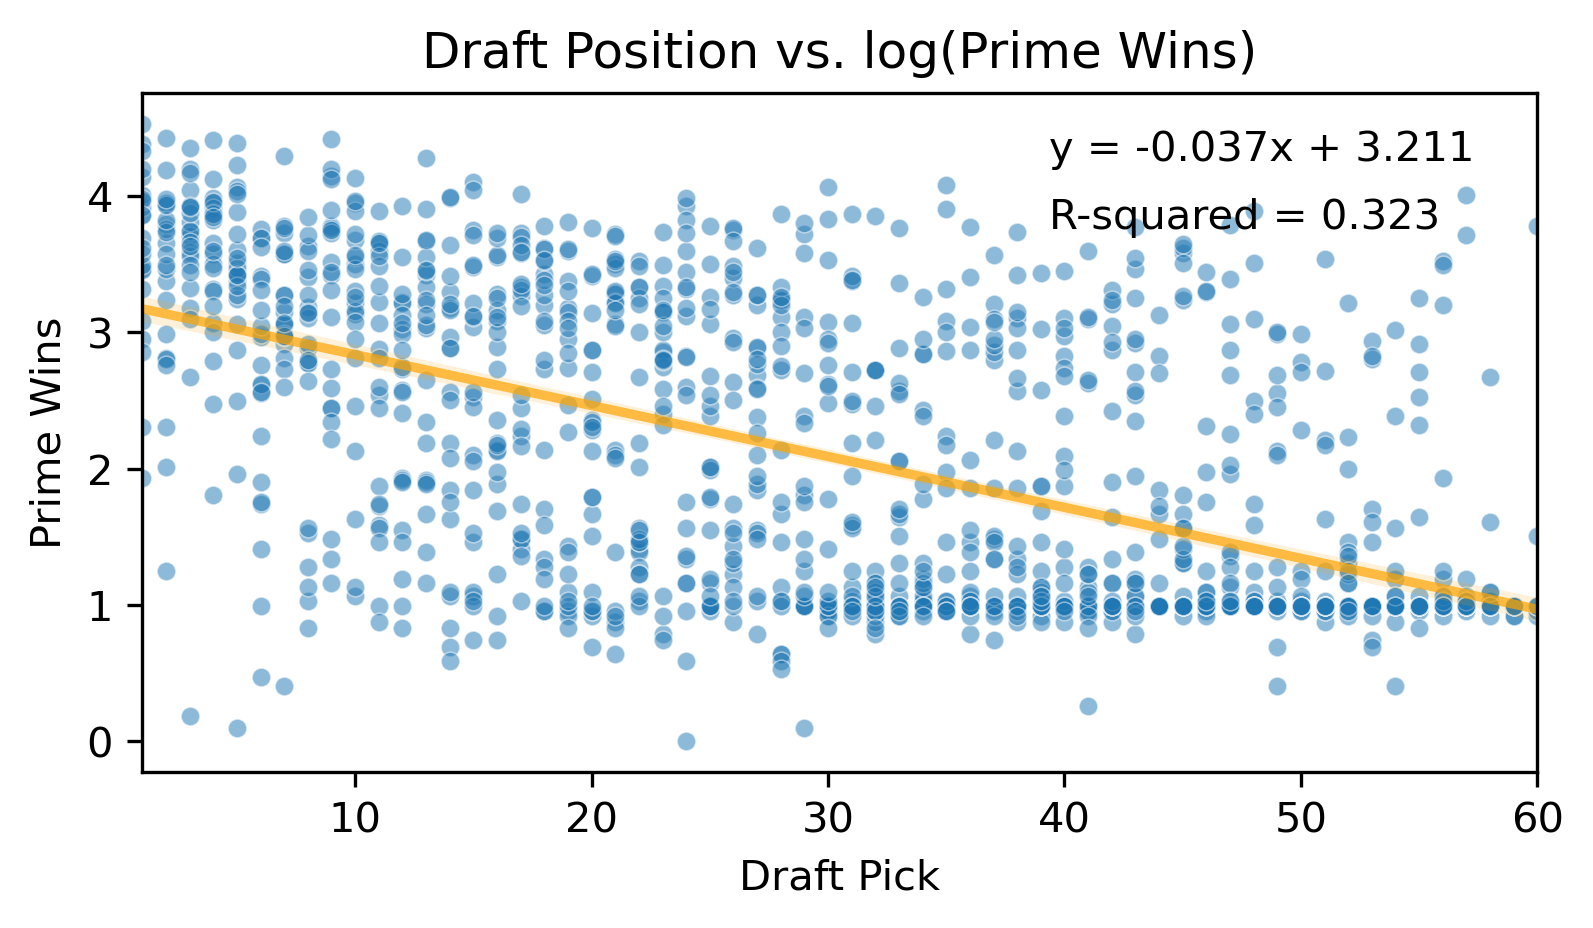

In [69]:
fig, ax = plt.subplots(figsize=(6,3), dpi = 300)

sns.scatterplot(x=df_prime['Pk'], y=df_prime['log_PrimeWS'], s=20, alpha=0.5)
sns.regplot(x=df_prime['Pk'], y=df_prime['log_PrimeWS'], color='orange', line_kws=dict(alpha=0.7), scatter=False, ax=ax)

ax.text(0.65, 0.9, f'y = {modelLog.params[1]:.3f}x + {modelLog.params[0]:.3f}', transform=ax.transAxes)
ax.text(0.65, 0.8, f'R-squared = {modelLog.rsquared:.3f}', transform=ax.transAxes)
plt.title('Draft Position vs. log(Prime Wins)')
plt.xlabel('Draft Pick')
plt.ylabel('Prime Wins')

We return a marginally stronger $R^2$ of **0.323**, but that isn't a particularly strong predictor.

#### Assumption 1 & 4: Linearity & Homoscedasticity 

While our lowess trendline is slightly curved, I wouldn't consider it to be extreme enough to be counted as an issue. The funnelling is no logner present so I would consider our data to be roughly linear/homoscedastic. 

Text(0.5, 1.0, 'Residual Plot')

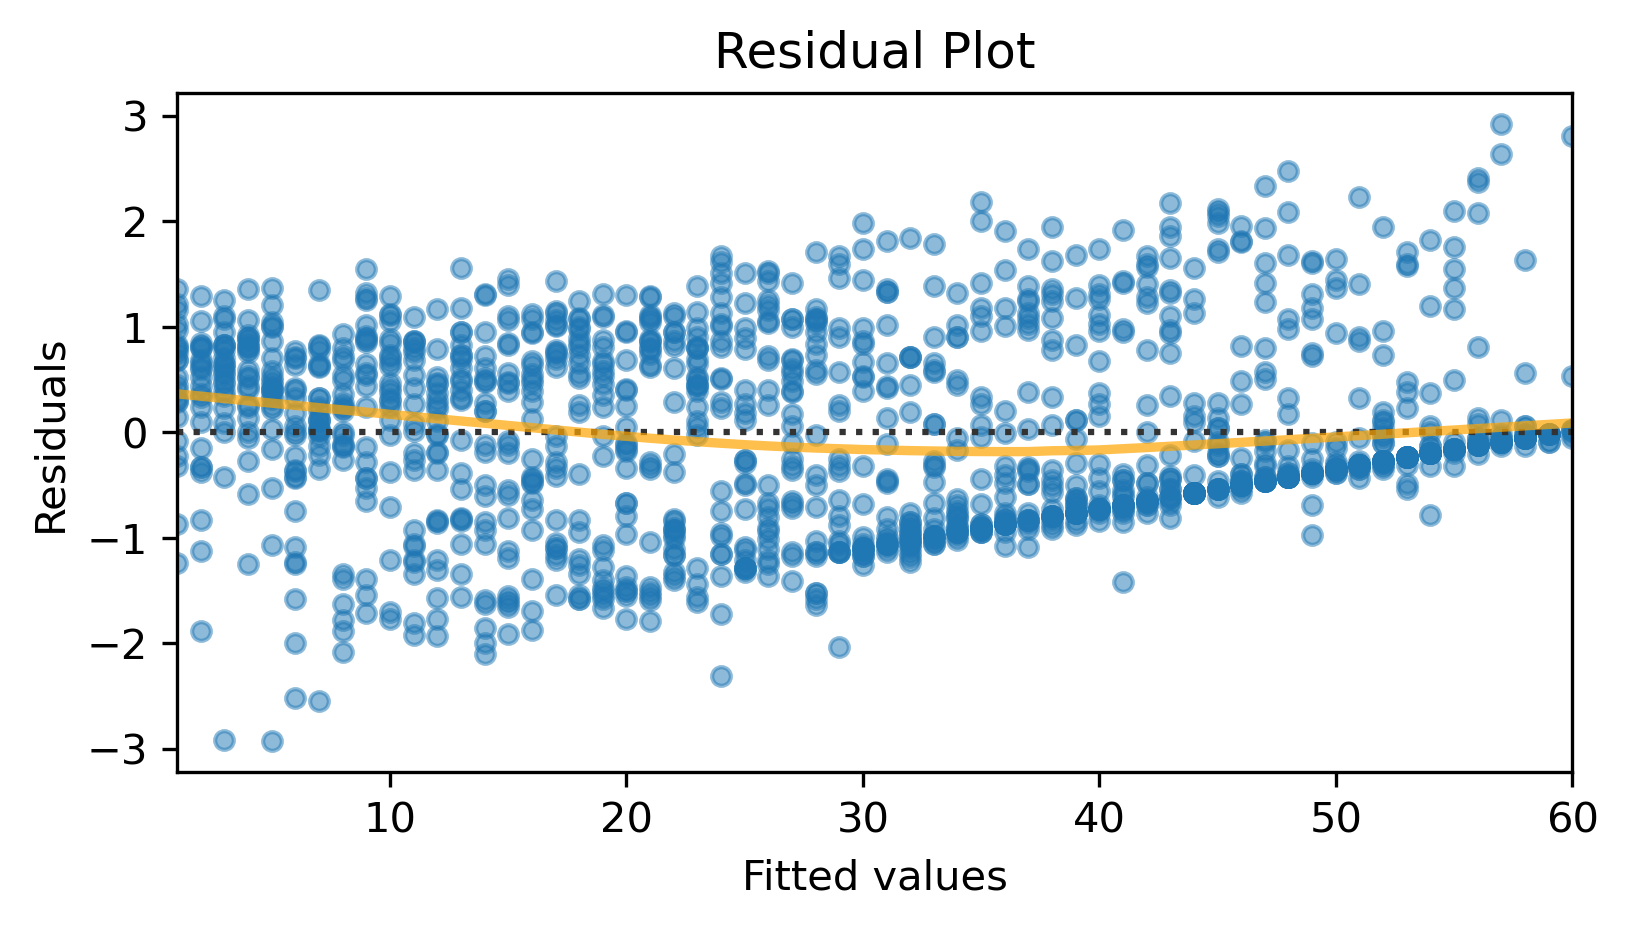

In [70]:
fig, ax = plt.subplots(figsize=(6,3), dpi = 300)

sns.residplot(x=df_prime['Pk'], y=df_prime['log_PrimeWS'], lowess=True, scatter_kws=dict(s=20, alpha=0.5), line_kws= dict(color='orange', alpha=0.7))
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

#### Assumption 2: Independance 

Again **our Durbin-Watson metric** is between 1.5 to 2.5 (**1.912**). So we fulfill our assumption of independance

#### Assumption 3: Normality cont.

The historgram of residuals and QQ plot look much better now, things look approximately normal.

Text(0.5, 1.0, 'Normal Q-Q plot')

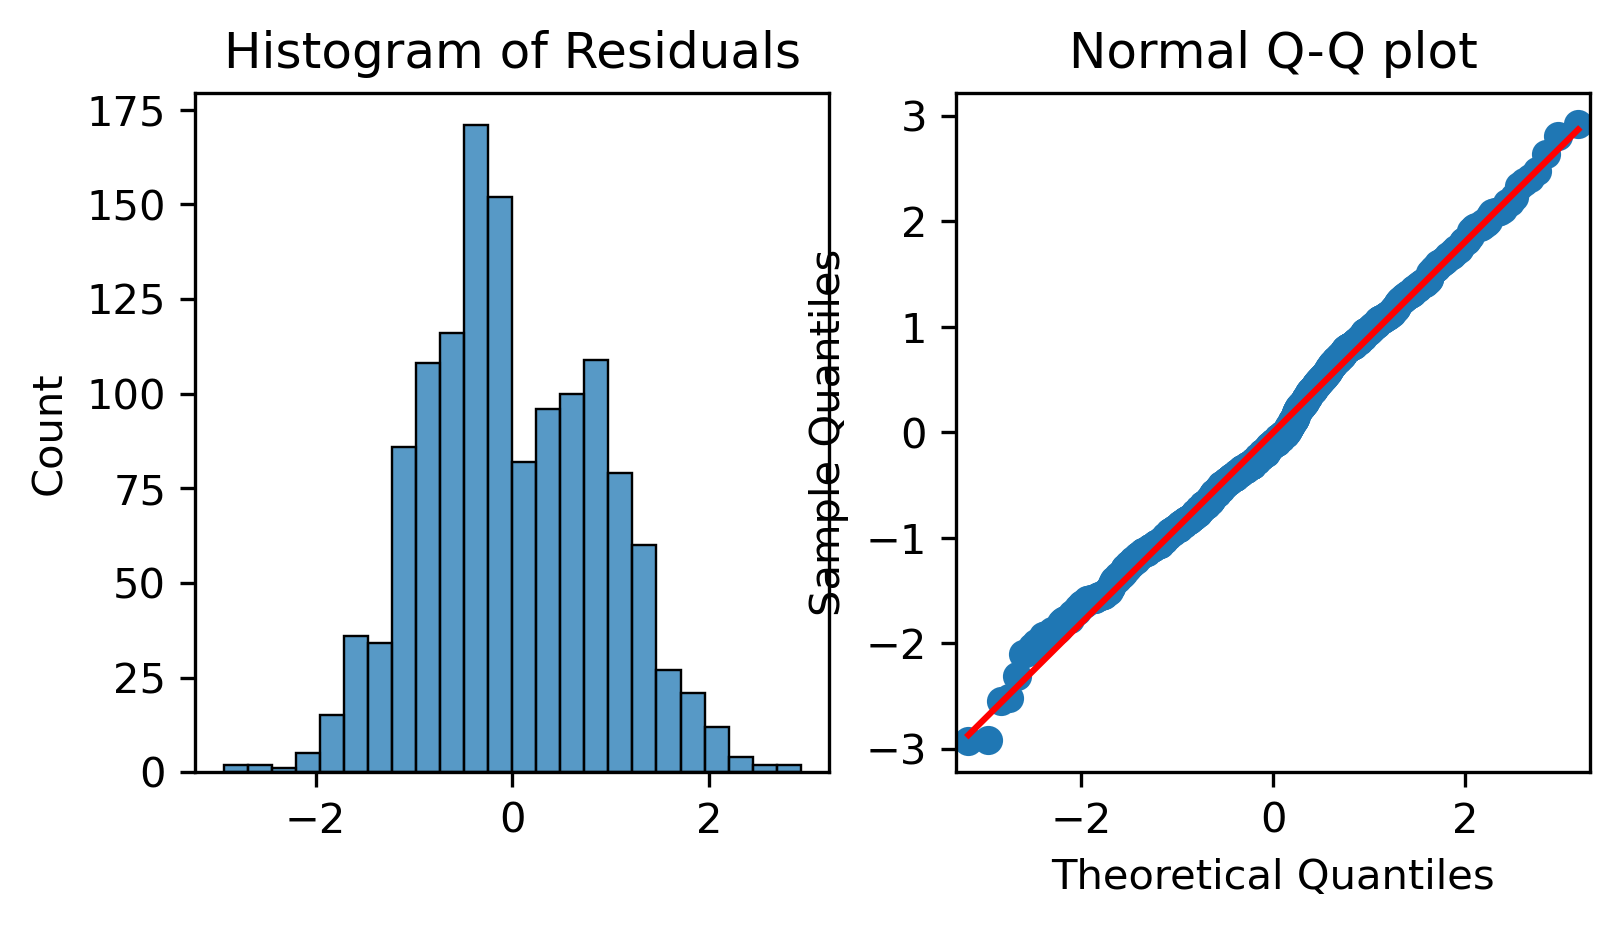

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=300) # 1 row, 2 columns

residualsLog = modelLog.resid
sns.histplot(residualsLog, ax = axes[0])
axes[0].set_title('Histogram of Residuals')

sm.qqplot(residualsLog, line='s', ax = axes[1]);
plt.title('Normal Q-Q plot')

### 3.3 Exaimaning Distribution and Outliers by Draft Position

From the below boxplot, we see quite a few outliers. 

When we look at the mean and median Prime Wins of each draft pick, we see some unintuitive things,
- The 2nd pick has lower median and average Prime Wins than the 3rd pick
- the 6th pick has lower median and average Prime Wins than the 13th pick

<AxesSubplot:xlabel='Pk', ylabel='log_PrimeWS'>

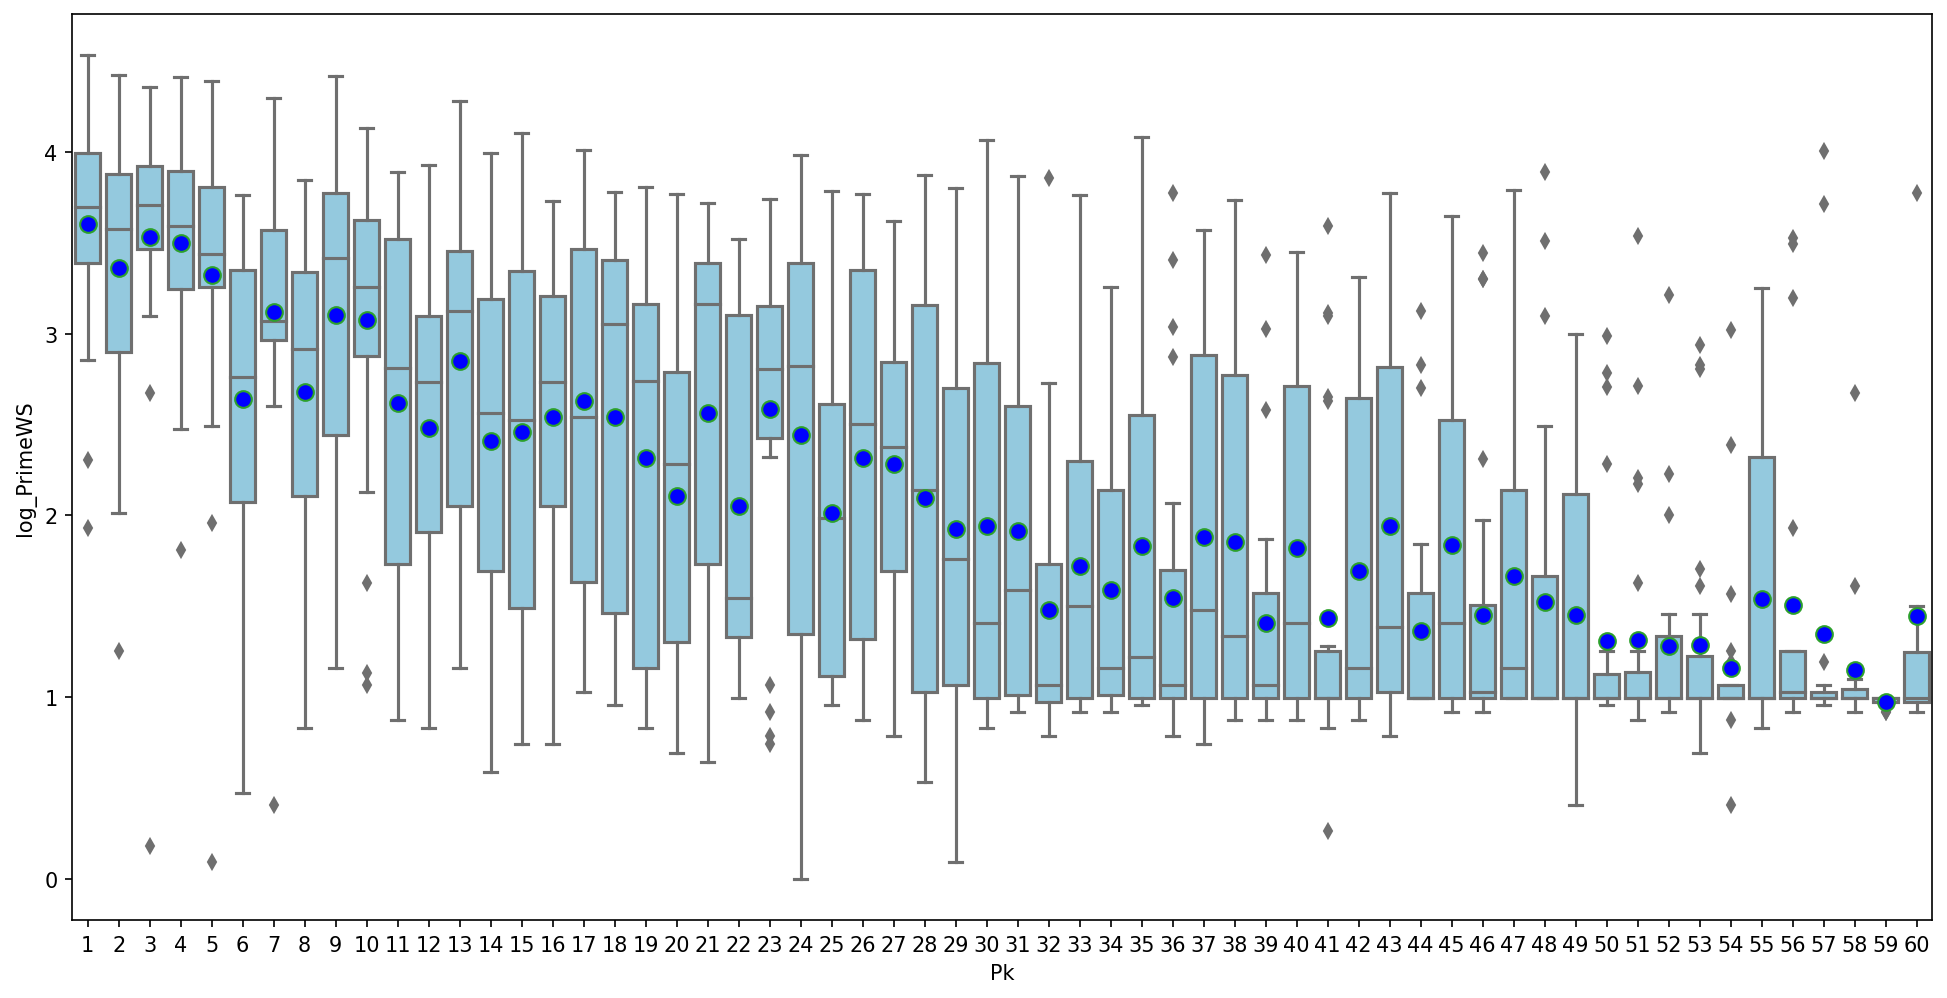

In [72]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 150)
sns.boxplot(x=df_prime['Pk'], y=df_prime['log_PrimeWS'], color = 'skyblue', showmeans=True
           , meanprops={'marker':'o', 'markerfacecolor':'b', 'markersize':'8'})

#### 3.3.1 Removing Outliers?

While it may be tempting to remove outliers to improve our R-squared, I think it wouldn't be helpful to do so. Draft "busts" and "steals" like Adam Morrison and Manu Ginóbili will likely never go away. In some ways, we are just modeling the uncertainty of the draft

#### 3.3.2 Re-Drafting?

In [my previous analysis of the NBA draft][1], I created a fantasy scenario where each team drafted "perfectly". While it was a fun exercise and the model returned a very high R-squared, it truly was just a fantasy scenario. The nature of the draft is uncertainty and risk, if each team drafted "perfectly" I may as well model the entire NBA wihtout considering draft position.


[1]:https://nbviewer.org/github/KayZhang34/NBA-Draft-Exploration/blob/main/The%20Expected%20Value%20of%20an%20NBA%20Draft%20Pick.ipynb "A notebook I made years ago"

### 3.4 Bagging

Applying bootstrap aggregation to reduce variance and the impact of outliers. This doesn't actually do too much for our model honestly, I just wanted to practice this technique.

In [73]:
from sklearn.utils import resample
np.random.seed(34)

coefs = []
r2 = []
equation = []

for _ in range(50):
    sample = df_prime.sample(n=len(df_prime), replace = True)
    OLSSample = ols(formula = ols_formulaLOG, data = sample)
    modelSample = OLSSample.fit()
    
    coefs.append(modelSample.params)
    r2.append(modelSample.rsquared)
    equation.append(
        f'y = {modelSample.params[0]:.3f} + {modelSample.params[1]:.3f}x1'
    )
mean_coefs = np.mean(coefs, axis=0)

In [74]:
print(f'Bagged OLS Equation: log(Prime Wins) = {mean_coefs[0]:.3f} + {mean_coefs[1]:.4f} * Draft Position')
print(f'Mean R²: {np.mean(r2):.3f} (±{np.std(r2):.3f})')

Bagged OLS Equation: log(Prime Wins) = 3.216 + -0.0375 * Draft Position
Mean R²: 0.326 (±0.022)


### 4.0 Applying our Model

In this next section, I want to dive in to specific examples in NBA history where teams have traded draft picks. This model is not extremely predictive  as the $R^2$ is still pretty weak at **0.326**. This should still be an interesting exercise.

$$
\text{Prime Wins} = e^{(-0.0366 \times \text{Draft Position}) + 3.167} - 2.70
$$

*Note: We are subtracting out 2.70 from our resutls, because in our original log transform, we also translated our data by adding 2.7 because we had players with negative prime wins in the dataset*

In [75]:
def model(draftPosition): 
    return np.exp((mean_coefs[1] * draftPosition) + mean_coefs[0])-translation

In [76]:
model(8)

15.776114874359596

In [77]:
model(18) + model(19) + model(58)

19.670508399709757

#### Example 1: The 1995 Shawn Respert Trade

June 28th 1995, the Detroit Pistons and the Portland Trail Blazers swapped a few selections that they had made that same day.

This is a good trade to analyze, as these picks are all from the same draft, the draft position had already been known, and none of these draftees had played in the NBA yet so everyone was still an uncertain prospect.

**Detroit Pistons**: 
* Traded Away: 1995 Pick \#8. (i.e. Shawn Respert)
* Recieved: 1995 Pick \#18, 1995 Pick \#19, and 1995 Pick \#58. (i.e. Theo Ratliff, Randolph Childress, and Don Reid)

**Portland Trail Blazers**:
* Traded Away: 1995 Pick \#18, 1995 Pick \#19, and 1995 Pick \#58. (i.e. Theo Ratliff, Randolph Childress, and Don Reid)
* Recieved: 1995 Pick \#8. (i.e. Shawn Respert)

**Modeled**: If we were to use our log transformed model to predict Prime Win Shares (Section 4.0)
* Trail Blazers Recieved: \#8. This pick is expected to provide **15.776 Prime Wins**
* Pistons Received: \#18, \#19, and \#58, These picks are expected to provide **19.671 Prime Wins**

Our model suggests that the Blazers slightly lose this trade by around 4 Prime Wins. This is a pretty negligible margin, and this trade doesn't seem that bad/good for side.

**Actual**:
* Trail Blazers recieved the \#8 pick which became : Shawn Respert: 2.1
* Pistons received picks that became: Theo Ratliff: 28.1, Randolph Childress: -0.2, and Don Reid: 11.8

In reality, the Trail Blazers lose this trade badly, and none of the modeled draft picks come very close to their respective projections.

Who knew Sixers Legend Theo Ratliff would be such a beast.

## 5. Bins by Draft Position (Lottery, Second Round, etc.)

In the NBA Draft, 'Lottery Picks' refer to the top 14 picks. These are refered to as the lottery because the bottom 14 teams are all drawing for the top 4 picks. If we group our draft positions by the way the NBA typically groups them, how does our model look?

- 1-4: Top Picks
- 5-14: Lottery Picks
- 15-30: First Round
- 31-60: Second Round

In [78]:
cuts = [0, 5, 15, 31, 60]
bins = ['Top Pick', 'Lottery Pick', 'First Round', 'Second Round']
bins_encoded = [0, 1, 2, 3]

df_bin = df_prime.copy()
df_bin['Bin'] =  pd.cut(df_prime['Pk'], cuts, labels= bins)
df_bin['Bin_encoded'] =  pd.cut(df_prime['Pk'], cuts, labels= bins_encoded)

In [79]:
# Creating OLS model
ols_formulaBin = 'log_PrimeWS ~ Bin_encoded'
OLSBin = ols(formula = ols_formulaBin, data = df_bin)
modelBin = OLSBin.fit()
modelBin_results = modelBin.summary()
# Display the model results.
modelBin_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_PrimeWS   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     210.6
Date:                Sat, 24 May 2025   Prob (F-statistic):          1.32e-111
Time:                        11:02:51   Log-Likelihood:                -1741.7
No. Observations:                1322   AIC:                             3491.
Df Residuals:                    1318   BIC:                             3512.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.4655      0.084     41.071      0.000       3.300       3.631
Bin_encoded[T.1]    -0.7215      0.103     -6.981      0.000      -0.924      -0.519
Bin_encoded[T.2]    -1.1964      0.097    -12.369      0.000      -1.386      -1.007
Bin_encoded[T.3]    -1.9339      0.092    -21.026      0.000      -2.114      -1.753
==============================================================================
Omnibus:                       17.925   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.191
Skew:                           0.245   Prob(JB):                     0.000185
Kurtosis:                       2.732   Cond. No.                         8.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.7, 0.9, 'R-squared = 0.324')

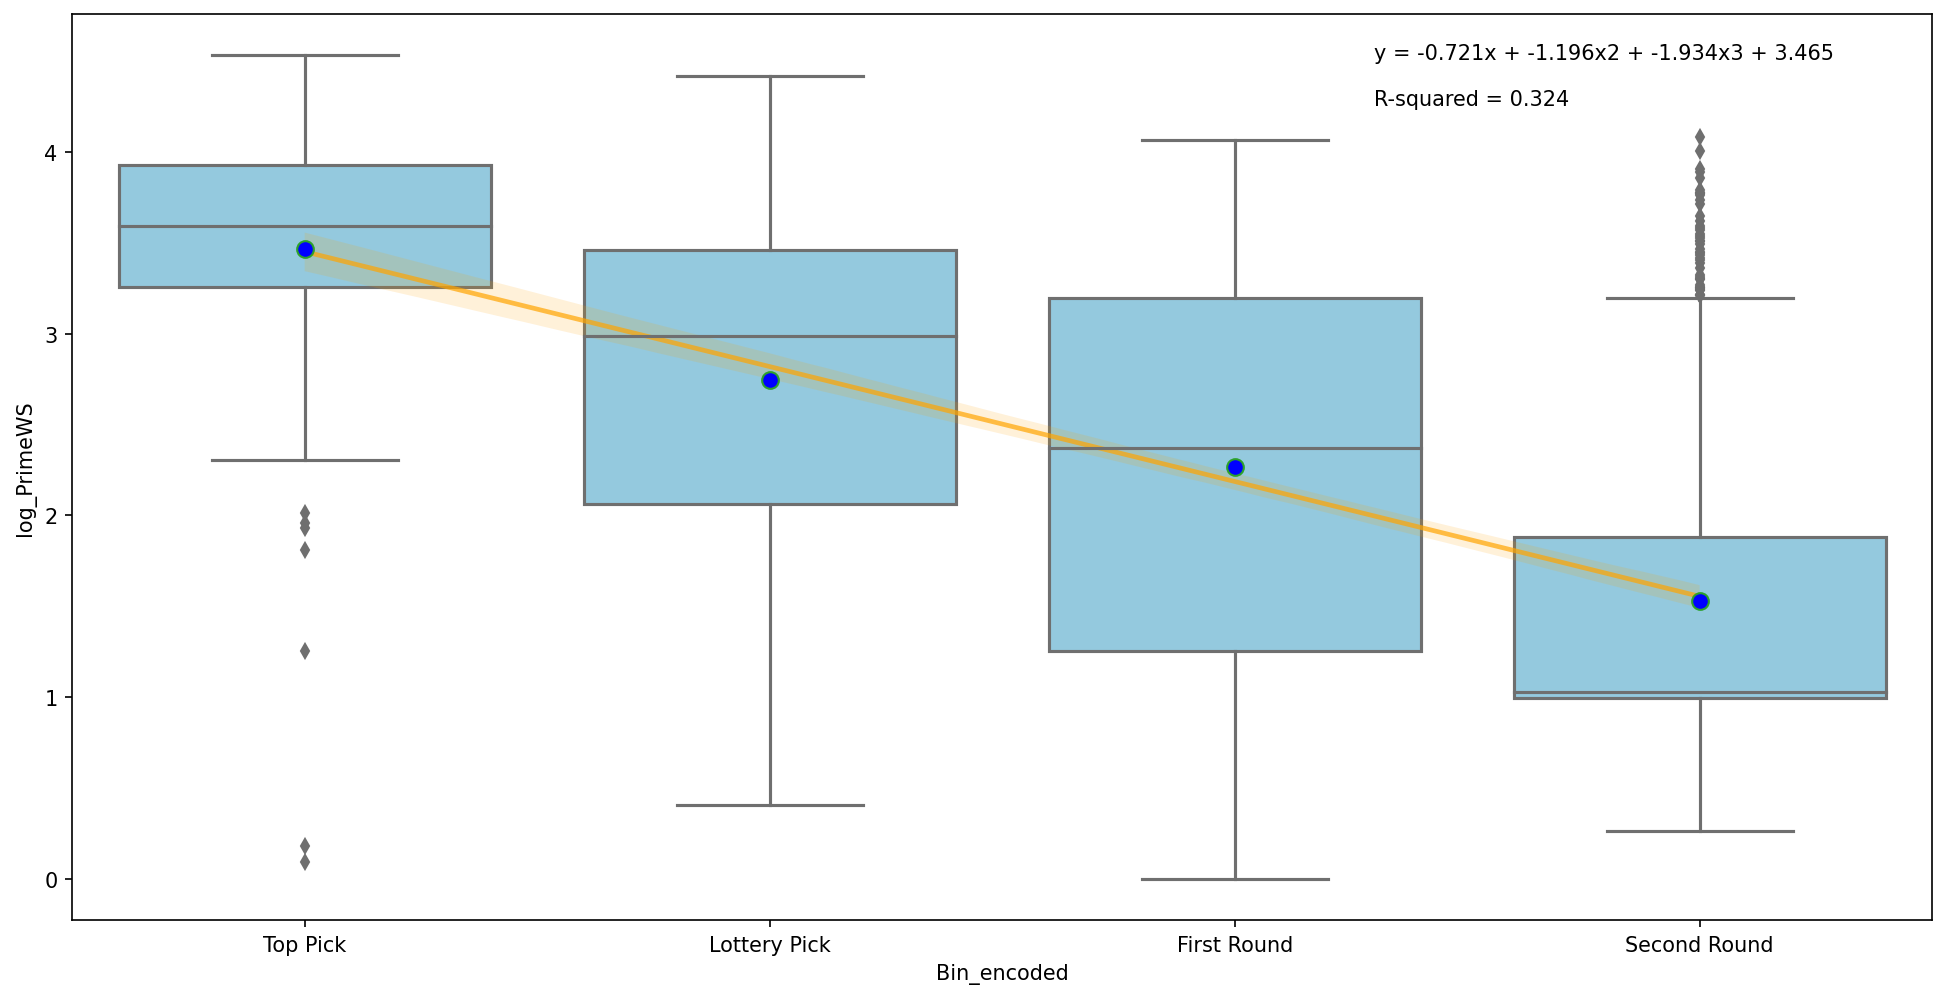

In [80]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 150)
sns.boxplot(x=df_bin['Bin'], y=df_bin['log_PrimeWS'], color = 'skyblue', showmeans=True
           , meanprops={'marker':'o', 'markerfacecolor':'b', 'markersize':'8'})
sns.regplot(x=df_bin['Bin_encoded'], y=df_bin['log_PrimeWS'], color='orange', line_kws=dict(alpha=0.7), scatter=False, ax=ax)

ax.text(0.7, 0.95, f'y = {modelBin.params[1]:.3f}x + {modelBin.params[2]:.3f}x2 + {modelBin.params[3]:.3f}x3 + {modelBin.params[0]:.3f}', transform=ax.transAxes)
ax.text(0.7, 0.9, f'R-squared = {modelBin.rsquared:.3f}', transform=ax.transAxes)

In [81]:
coefsBin = []
r2Bin = []
equationBin = []

for _ in range(50):
    sampleBin = df_bin.sample(n=len(df_bin), replace = True)
    OLSSampleBin = ols(formula = ols_formulaBin, data = sampleBin)
    modelSampleBin = OLSSampleBin.fit()
    
    coefsBin.append(modelSampleBin.params)
    r2Bin.append(modelSampleBin.rsquared)
    equationBin.append(
        f'y = {modelSampleBin.params[0]:.3f} + {modelSampleBin.params[1]:.3f}x1 + {modelSampleBin.params[2]:.3f}x2 + {modelSampleBin.params[3]:.3f}x3'
    )
mean_coefsBin = np.mean(coefsBin, axis=0)

In [82]:
print(f'Bagged OLS Equation: log(Prime Wins) = {mean_coefsBin[0]:.3f} + {mean_coefsBin[1]:.3f}*Lottery Pick + {mean_coefsBin[2]:.3f}*First Round + {mean_coefsBin[3]:.3f}*Second Round')
print(f'Mean R²: {np.mean(r2Bin):.3f} (±{np.std(r2Bin):.3f})')

Bagged OLS Equation: log(Prime Wins) = 3.471 + -0.728*Lottery Pick + -1.209*First Round + -1.943*Second Round
Mean R²: 0.328 (±0.023)


### 5.1 Applying this Model

In this next section, I want to dive in to specific examples in NBA history where teams have traded draft picks. This model is not extremely predictive  as the $R^2$ is still pretty weak at **0.328**. This should still be an interesting exercise.

$$
\text{Prime Wins} = e^{(-0.724 \times \text{Lottery Pick}) + (-1.188 \times \text{First Round}) + (-1.899 \times \text{Second Round}) + 3.420} - 2.70
$$

*Note: We are subtracting out 2.70 from our resutls, because in our original log transform, we also translated our data by adding 2.7 because we had players with negative prime wins in the dataset*

In [83]:
def modelBin(draftPosition): 
    if draftPosition < cuts[1]:
        x = 0
    elif draftPosition < cuts[2]:
        x = 1
    elif draftPosition < cuts[3]:
        x = 2
    else:
        x = 3
    return np.exp((mean_coefsBin[x]) + mean_coefsBin[0])-translation

In [84]:
modelBin(8)

12.834283932021137

In [85]:
modelBin(18) + modelBin(19) + modelBin(58)

15.722452835983066

**Modeled**: If we were to use our log transformed model to predict Prime Win Shares (Section 4.0)
* Trail Blazers Recieved: \#8. This pick is expected to provide **12.834 Prime Wins**
* Pistons Received: \#18, \#19, and \#58, These picks are expected to provide **15.772 Prime Wins**

Our doesn't change too much and is still fairly innacurate. This time the model suggests that the Blazers slightly lose this trade by around 3 Prime Wins.


# 6.0 Conclusion: Lost in the Sauce?

I think the uncertainty of the NBA draft is part of the game. Maybe the only interesting (albeit intuitive) takeaway is that the difference in draft position matters MORE earlier in the draft *(e.g. the difference between the 1st pick and the 5th pick is bigger than the 51st pick and the 55th pick)*. 

The model was fun to build, and we found some interesting trends, but ultimately I might be lost in the sauce.

## 7.0 Additional Analysis for Fun

While the model isn't so accurate at predicting prime wins, I think our dataset can still be fun to play with!

### 7.1 The Best Draft and Worst Draft Class?

While the NBA draft is already full of athletic freaks and outliers, I'm curious if there is any draft contains even more extreme outliers.

What we see below is the best 5 draft classes by TOTAL win shares.

In [86]:
df_year = df_prime.groupby('Year').agg({'Prime_WS':'sum'})

df_sorted = df_year.sort_values(by='Prime_WS', ascending = False)
df_sorted.head(3)

,Prime_WS
Year,
2008,862.5
1996,842.5
2009,834.8


In [87]:
df_prime[df_prime['Year']==2008].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
1085,Russell Westbrook,59.4,2008,4,200804,4.128746
1116,DeAndre Jordan,56.6,2008,35,200835,4.082609
1086,Kevin Love,52.9,2008,5,200805,4.018183
1105,Serge Ibaka,38.9,2008,24,200824,3.728100
1091,Brook Lopez,38.6,2008,10,200810,3.720862
1107,George Hill,36.5,2008,26,200826,3.668677
1126,Goran Dragić,35.6,2008,45,200845,3.645450
1087,Danilo Gallinari,34.8,2008,6,200806,3.624341
1082,Derrick Rose,33.1,2008,1,200801,3.577948
1102,Ryan Anderson,31.8,2008,21,200821,3.540959


In [88]:
df_prime[df_prime['Year']==1996].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
394,Kobe Bryant,69.7,1996,13,199613,4.282206
396,Steve Nash,58.0,1996,15,199615,4.105944
386,Ray Allen,55.6,1996,5,199605,4.065602
382,Allen Iverson,52.2,1996,1,199601,4.005513
395,Peja Stojaković,51.7,1996,14,199614,3.996364
385,Stephon Marbury,45.6,1996,4,199604,3.877432
384,Shareef Abdur-Rahim,42.3,1996,3,199603,3.806662
401,Zydrunas Ilgauskas,40.6,1996,20,199620,3.768153
383,Marcus Camby,40.1,1996,2,199602,3.756538
389,Kerry Kittles,38.3,1996,8,199608,3.713572


In [89]:
#The best players from the 2009 Draft Class

df_prime[df_prime['Year']==2009].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
1144,James Harden,75.3,2009,3,200903,4.356709
1148,Stephen Curry,70.8,2009,7,200907,4.297285
1142,Blake Griffin,50.8,2009,1,200901,3.979682
1150,DeMar DeRozan,46.5,2009,9,200909,3.895894
1159,Ty Lawson,34.3,2009,18,200918,3.610918
1160,Jeff Teague,33.8,2009,19,200919,3.597312
1158,Jrue Holiday,33.6,2009,17,200917,3.591818
1162,Darren Collison,31.1,2009,21,200921,3.520461
1187,Danny Green,28.7,2009,46,200946,3.446808
1167,Taj Gibson,28.6,2009,26,200926,3.443618


In [90]:
#The worst 3 draft classes by total Prime Wins

df_sorted.tail(3)

,Prime_WS
Year,
1991,549.4
2006,542.3
2000,509.8


In [91]:
df_prime[df_prime['Year']==2000].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
655,Michael Redd,40.8,2000,43,200043,3.772761
628,Hedo Türkoğlu,37.4,2000,16,200016,3.691376
617,Mike Miller,29.5,2000,5,200005,3.471966
613,Kenyon Martin,29.0,2000,1,200001,3.456317
620,Jamal Crawford,27.5,2000,8,200008,3.407842
631,Jamaal Magloire,24.6,2000,19,200019,3.306887
633,Morris Peterson,24.6,2000,21,200021,3.306887
630,Quentin Richardson,23.7,2000,18,200018,3.273364
629,Desmond Mason,21.6,2000,17,200017,3.190476
621,Joel Przybilla,19.8,2000,9,200009,3.113515


In [92]:
df_prime[df_prime['Year']==2006].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
985,Kyle Lowry,51.1,2006,24,200624,3.985273
963,LaMarcus Aldridge,50.9,2006,2,200602,3.981549
1008,Paul Millsap,41.6,2006,47,200647,3.790985
982,Rajon Rondo,38.2,2006,21,200621,3.711130
967,Brandon Roy,37.5,2006,6,200606,3.693867
972,JJ Redick,32.4,2006,11,200611,3.558201
969,Rudy Gay,29.0,2006,8,200608,3.456317
975,Ronnie Brewer,27.6,2006,14,200614,3.411148
996,P.J. Tucker,25.0,2006,35,200635,3.321432
974,Thabo Sefolosha,22.7,2006,13,200613,3.234749


In [93]:
df_prime[df_prime['Year']==1991].nlargest(10, 'Prime_WS')

,Player,Prime_WS,Year,Pk,ID,log_PrimeWS
111,Dikembe Mutombo,51.0,1991,4,199104,3.983413
118,Terrell Brandon,46.2,1991,11,199111,3.889777
112,Steve Smith,46.0,1991,5,199105,3.885679
108,Larry Johnson,44.8,1991,1,199101,3.860730
109,Kenny Anderson,41.7,1991,2,199102,3.793239
120,Dale Davis,36.6,1991,13,199113,3.671225
116,Stacey Augmon,27.8,1991,9,199109,3.417727
131,Rick Fox,25.0,1991,24,199124,3.321432
128,Eric Murdock,24.2,1991,21,199121,3.292126
152,Bobby Phills,22.8,1991,45,199145,3.238678


### 7.1.1 What makes a draft class "good"?

All these draft classes are good, but more than that what the above shows me more is that there is a fault in trying to quanitify player greatness. While it is impossible to have a perfect measure for anything that's as vague as "player value", I think people would **strongly disagree** with the below suggestions made by our Prime Wins measure:
- James Harden being better than Kobe Bryant and Steph Curry 
- Jeff Teague being better than Jrue Holiday
- Deandre Jordan being better than Allen Iverson

Our data is not based on playoff performance and since we are using total win shares, players that play less games/minutes are penalized. This is just the difficulty of assessing player quality as a number. 

It might make more sense to figure out the draft with the most number of above average players? Maybe we can see which draft might have the most players in the top 10% of Prime Wins 

In [95]:
wsCutoff = df_prime.nlargest(round(len(df_prime)/10), 'Prime_WS')['Prime_WS'].iloc[-1]
df_prime.nlargest(round(len(df_prime)/10), 'Prime_WS')

dfYear_CO = df_prime[df_prime['Prime_WS']>=wsCutoff].groupby('Year').count().sort_values(by='Prime_WS', ascending = False)
dfYear_CO.head(5)

,Player,Prime_WS,Pk,ID,log_PrimeWS
Year,,,,,
1999,12,12,12,12,12
1996,11,11,11,11,11
2001,11,11,11,11,11
1989,8,8,8,8,8
2011,8,8,8,8,8


#### 7.1.2 What is the best draft class, conclusion

Think of how to display the above data, perhaps having 50 names is a bit oberwhelming

### 7.2 The Biggest Draft Steals/Busts?

We see that the biggest outliers by zscore are Manu Ginobili, Nikoloz Tskitishvili, Adam Morrison, and Isaiah Thomas. 

By our metric, we can claim that Manu Ginóbili and Isaiah Thomas are the biggest draft-day steals, and unfortunately Nikoloz Tskitishvili and Adam Morrison are the biggest draft-day busts

In [ ]:
SE = np.std(residualsLog, ddof=len(modelLog.params))
zscores = stats.zscore(residualsLog)

outlier_index = abs(zscores) > 3
outliers  = df_prime[outlier_index]

print(outliers)